In [853]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [854]:
ee.Initialize()

In [855]:
import urllib, tempfile, zipfile
def download_tiff(image, scale):
    url = ee.data.makeDownloadUrl(ee.data.getDownloadId({
        'image': image.serialize(),
        'scale': '%d' % scale,
        'filePerBand': 'false',
        'name': 'data',
    }))
    local_zip, headers = urllib.urlretrieve(url)
    with zipfile.ZipFile(local_zip) as local_zipfile:
        return local_zipfile.extract('data.tif', tempfile.mkdtemp())

In [856]:
dataset_path = 'LANDSAT/LC08/C01/T1_TOA'
#path, row = [3, 69] # RMDD
#path, row = [76, 16] # Western AK
#path, row = [25, 37] # Western AK
path, row = [25, 38] # TX/LA border

start_date = '2014-01-01'
end_date = '2015-01-01'

collection = ee.ImageCollection(dataset_path) \
    .filter(ee.Filter.eq('WRS_PATH', path)) \
    .filter(ee.Filter.eq('WRS_ROW', row)) \
    .filterDate(start_date, end_date)

In [857]:
cloud_thresh = ee.Number(25.0)
filtered = collection.filterMetadata('CLOUD_COVER', 'less_than', cloud_thresh)

In [858]:
vis_params = {'bands' : 'B5, B6, B4'} # XXX: bands should be a string, not list...

In [859]:
img = ee.Image(filtered.sort('CLOUD_COVER').first())
print(img.bandNames().getInfo())
url = img.getThumbUrl(vis_params)
print(ee.Date(img.get('system:time_start')).format('Y-M-d').getInfo())

[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6', u'B7', u'B8', u'B9', u'B10', u'B11', u'BQA']
2014-3-13


In [860]:
Image(url=url)

In [861]:
used_bands = ['B5', 'B6', 'B4', 'B3', 'B2']
img = img.select(used_bands)
bands = img.bandNames().getInfo()
water_value, lc_value = [1, 2]

water = ee.Image('JRC/GSW1_0/MonthlyHistory/2014_03')
cur = water.eq(ee.Number(2)).multiply(ee.Number(water_value))
clipped_water = cur.clip(img.geometry())

In [862]:
#value = 16
#modis = ee.Image('MODIS/006/MCD12Q1/2016_01_01').select('LC_Type1').eq(ee.Number(value)).multiply(ee.Number(lc_value))
#clipped_modis = modis.clip(img.geometry())
clipped_labels = clipped_water#.add(clipped_modis)
#clipped_labels = clipped_labels.multiply(clipped_labels.lte(ee.Number(lc_value)))

In [863]:
stacked = img.select(bands).addBands(clipped_labels)
bands = stacked.bandNames().getInfo()
bands.remove('water')
bands.append('label')
stacked = stacked.rename(bands)

In [864]:
filename = download_tiff(clipped_water, scale=200)

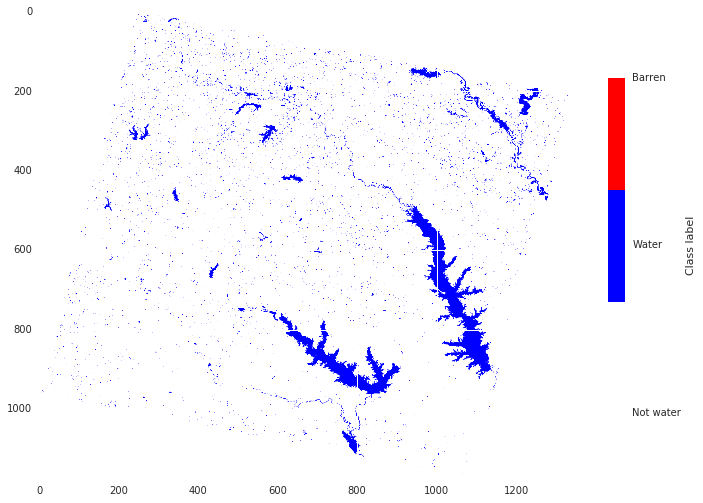

In [865]:
cmap = colors.ListedColormap(['white', 'blue', 'red'])
bounds = [0, 0.5, 1.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)
with rasterio.open(filename) as r:
    jrc = r.read(1)
#print(results.shape)
#results = np.stack([results[4], results[3], results[2]], axis=-1)
#print(results.shape)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(jrc, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, label='Class label', ticks=[0, 1, 2])
cb.ax.set_yticklabels(['Not water', 'Water', 'Barren']);

In [866]:
print(bands)

[u'B5', u'B6', u'B4', u'B3', u'B2', 'label']


In [867]:
training = stacked.sample(numPixels=10000, seed=0).select(bands)
validation = stacked.sample(numPixels=10000, seed=1).select(bands)

In [868]:
classifier = ee.Classifier.svm().train(training, 'label')

In [869]:
classified = stacked.classify(classifier, 'classification')

In [870]:
validated = validation.classify(classifier, 'classification')
accuracy = validated.errorMatrix('label', 'classification')
print(accuracy.accuracy().getInfo())

0.998095619926


In [871]:
filename = download_tiff(classified.clip(img.geometry()), scale=200)

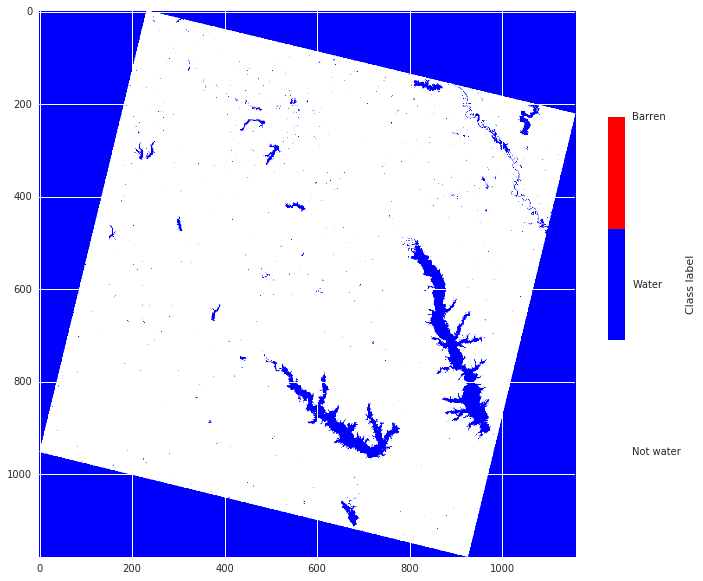

In [872]:
cmap = colors.ListedColormap(['white', 'blue', 'red'])
bounds = [0, 0.5, 1.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)
with rasterio.open(filename) as r:
    results = r.read(1)
#print(results.shape)
#results = np.stack([results[4], results[3], results[2]], axis=-1)
#print(results.shape)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = plt.imshow(results, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, label='Class label', ticks=[0, 1, 2])
cb.ax.set_yticklabels(['Not water', 'Water', 'Barren']);

In [873]:
omission = clipped_labels.eq(ee.Number(water_value)).And(classified.neq(ee.Number(water_value))).multiply(ee.Number(-1))
comission = clipped_labels.neq(ee.Number(water_value)).And(classified.eq(ee.Number(water_value)))
error = omission.add(comission)
filename = download_tiff(error, scale=240)

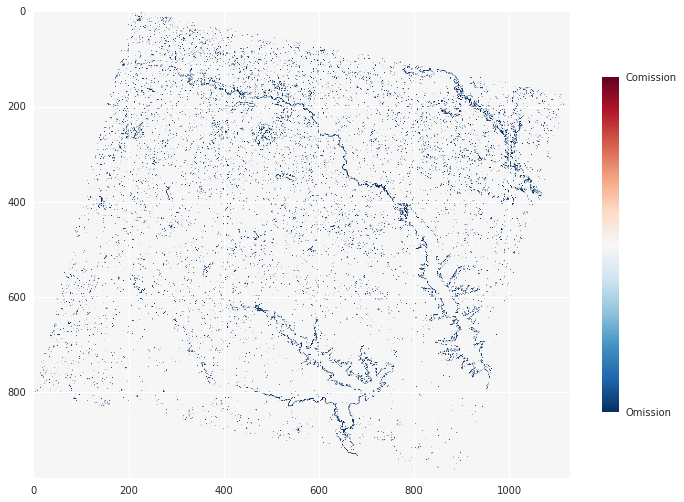

In [874]:
with rasterio.open(filename) as r:
    err = r.read(1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(err, cmap='RdBu_r', vmin=-1, vmax=1) #, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['Omission', '', 'Comission']);

(400, 100)

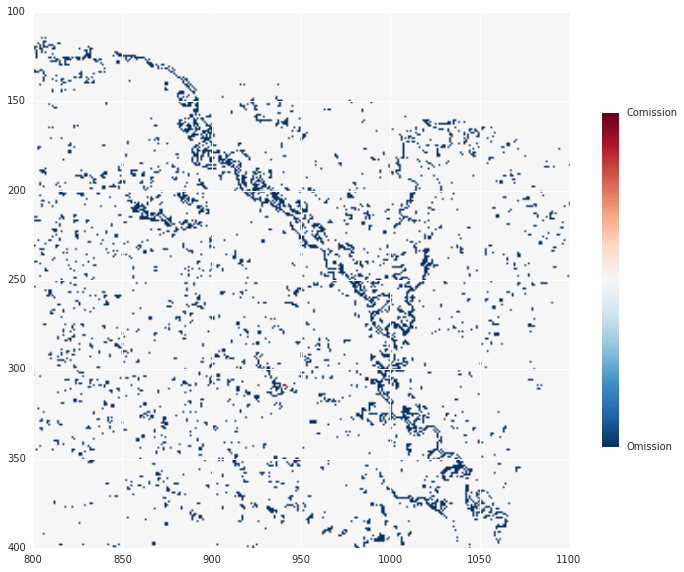

In [875]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(err, cmap='RdBu_r', vmin=-1, vmax=1) #, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['Omission', '', 'Comission']);
ax.set_xlim([800, 1100])
ax.set_ylim([400, 100])

(450, 150)

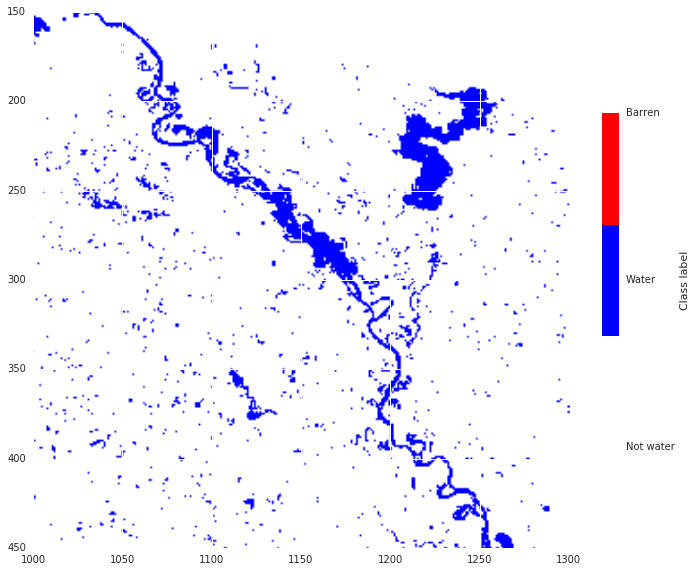

In [876]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = plt.imshow(jrc, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, label='Class label', ticks=[0, 1, 2])
cb.ax.set_yticklabels(['Not water', 'Water', 'Barren']);
ax.set_xlim([1000, 1300])
ax.set_ylim([450, 150])

(400, 100)

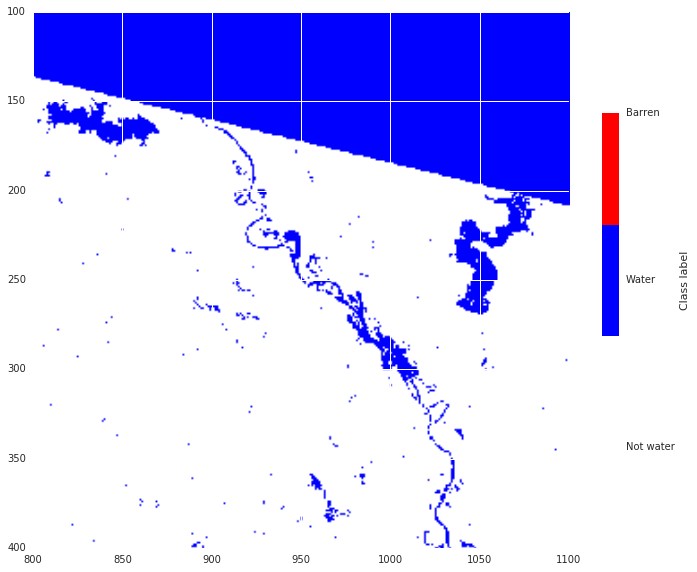

In [877]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = plt.imshow(results, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, label='Class label', ticks=[0, 1, 2])
cb.ax.set_yticklabels(['Not water', 'Water', 'Barren']);
ax.set_xlim([800, 1100])
ax.set_ylim([400, 100])